# Inferencia Bayesiana con métodos MonteCarlo: Cadenas de Markov

Probamos el método de Metropolis-Hasting para MCMC y lo comparamos con la función de luminosidad en función de la magnitud absoluta de la banda r del Sloan, medidas en el trabajo de Blanton et al. (2001).

In [1]:
import numpy as np
import pandas as pd 
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
d = pd.read_table('datos.dat',sep='\t', header=None, names=['Magnitud','Fl_inf','Flujo','Fl_sup'])
Fer_i = d['Flujo']-d['Fl_inf']
Fer_s = d['Fl_sup']-d['Flujo']
M = d['Magnitud']
F = d['Flujo']

En el gráfico se ven los puntos junto con sus errores en escala logarítmica

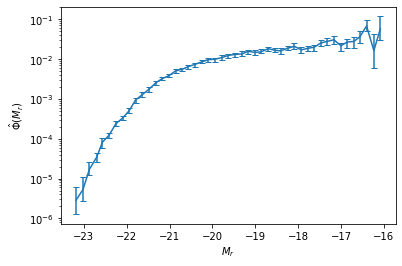

In [3]:
plt.errorbar(d['Magnitud'],d['Flujo'],yerr=[Fer_i,Fer_s], capsize=3)
plt.xlabel('$M_r$')
plt.ylabel('$\hat{\Phi}(M_r)$')
plt.yscale('log')

Escribo la función del modelo, el Likelihood, un prior uniforme y uno normal y la posteriori todos exepto el modelo tomando el logaritmo.
Después escribo la cadena según el algoritmo elegido (MH).

In [4]:
def mod(M,Ms,fs,a):
    """ Modelo de Blanton para los flujos
    M  : Magnitud observada
    Ms : Manitud del modelo
    fs : Flujo del modelo
    a  : alpha del modelo
    """
    import numpy as np
    Fm = np.zeros(len(M))
    Fm = 0.4*np.log(10)*fs*10**(-0.4*(M-Ms)*(a+1))*np.exp(-10**(-0.4*(M-Ms)))
    return Fm

In [5]:
def lkl(M,F,Fer_i,Fer_s,Ms,fs,a):
    """ Logaritmo del likelihood 
    para distribución normal alrededor de cada punto
    M     : Magnitud observada
    F     : Flujo observado
    Fer_i : Flujo inferior obs.
    Fer_s : Flujo superior obs.
    Ms    : Manitud del modelo
    fs    : Flujo del modelo
    a     : alpha del modelo
    """
    Fm = mod(M,Ms,fs,a)
    import scipy.stats as st
    lk = st.norm(Fm,(Fer_i[:]+Fer_s[:])*0.5).pdf(F)
    lk = np.log(lk)
    lk =  np.sum(lk)
    return lk

In [6]:
def priorU(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Prior Uniforme
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud mínima del modelo
    Ms_s : Magnitud máxima del modelo
    fs_i : Flujo mínima del modelo
    fs_s : Flujo máxima del modelo
    a_i  : alpha mínima del modelo
    a_s  : alpha máxima del modelo
    """
    import scipy.stats as st
    Mpr = st.uniform.pdf(Ms,loc=Ms_i,scale=(Ms_s-Ms_i))
    Fpr = st.uniform.pdf(fs,loc=fs_i,scale=(fs_s-fs_i))
    apr = st.uniform.pdf(a,loc=a_i,scale=(a_s-a_i))
    if (Mpr*Fpr*apr)==0:
        return -np.inf
    else:
        return np.log(Mpr*Fpr*apr)

In [7]:
def priorN(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Prior Normal
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud menor del modelo a un sigma del valor central
    Ms_s : Magnitud mayor del modelo a un sigma del valor central
    fs_i : Flujo menor del modelo a un sigma del valor central 
    fs_s : Flujo mayor del modelo a un sigma del valor central
    a_i  : alpha menor del modelo a un sigma del valor central
    a_s  : alpha mayor del modelo a un sigma del valor central
    """
    import scipy.stats as st
    Mpr = st.norm.pdf(Ms,loc=(Ms_i+Ms_s)*0.5,scale=0.5*(Ms_s-Ms_i))
    Fpr = st.norm.pdf(fs,loc=(fs_i+fs_s)*0.5,scale=0.5*(fs_s-fs_i))
    apr = st.norm.pdf(a,loc=(a_i+a_s)*0.5,scale=0.5*(a_s-a_i))
    if (Mpr*Fpr*apr)==0:
        return -np.inf
    else:
        return np.log(Mpr*Fpr*apr)

In [8]:
def postU(M,F,Fer_i,Fer_s,Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Posterior de un prior Uniforme
    M     : Magnitud observada
    F     : Flujo observado
    Fer_i : Flujo inferior obs.
    Fer_s : Flujo superior obs.
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud mínima del modelo
    Ms_s : Magnitud máxima del modelo
    fs_i : Flujo mínima del modelo
    fs_s : Flujo máxima del modelo
    a_i  : alpha mínima del modelo
    a_s  : alpha máxima del modelo
    """
    pos = lkl(M,F,Fer_i,Fer_s,Ms,fs,a) + priorU(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
    return pos

In [9]:
def postN(M,F,Fer_i,Fer_s,Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    """ Posterior de un prior Normal
    M     : Magnitud observada
    F     : Flujo observado
    Fer_i : Flujo inferior obs.
    Fer_s : Flujo superior obs.
    Ms   : Manitud del modelo
    fs   : Flujo del modelo
    a    : alpha del modelo
    Ms_i : Magnitud menor del modelo a un sigma del valor central
    Ms_s : Magnitud mayor del modelo a un sigma del valor central
    fs_i : Flujo menor del modelo a un sigma del valor central 
    fs_s : Flujo mayor del modelo a un sigma del valor central
    a_i  : alpha menor del modelo a un sigma del valor central
    a_s  : alpha mayor del modelo a un sigma del valor central
    """
    pos = lkl(M,F,Fer_i,Fer_s,Ms,fs,a) + priorN(Ms,fs,a,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
    return pos

In [10]:
def MCMC(n,M,F,Fer_i,Fer_s,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s):
    import numpy as np
    
    step    = []
    M_chain = []
    F_chain = []
    a_chain = []
    Mc = 0.5*(Ms_i+Ms_s)
    Fc = 0.5*(fs_i+fs_s)
    ac = 0.5*(a_i+a_s)
    delM = Ms_s-Ms_i
    delF = fs_s-fs_i
    dela = fs_s-fs_i
    
    post_0 = -11 # Mi posterior esta en logaritmo
    while post_0 < -10:
        Ms_0 = np.random.uniform(Ms_i, Ms_s)
        fs_0 = np.random.uniform(fs_i, fs_s)
        a_0  = np.random.uniform(a_i, a_s)
    
        post_0 = postU(M,F,Fer_i,Fer_s,Ms_0,fs_0,a_0,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
    
    i = 0
    step.append(i)
    M_chain.append(Ms_0)
    F_chain.append(fs_0)
    a_chain.append(a_0)
    
    while i+1<n:
        Ms_n = np.random.normal(loc= Ms_0, scale= 0.1*delM)
        fs_n = np.random.normal(loc= fs_0, scale= 0.1*delF)
        a_n  = np.random.normal(loc=  a_0, scale= 0.1*dela)
        
        post_n = postU(M,F,Fer_i,Fer_s,Ms_n,fs_n,a_n,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)
        
        # Probabilidad de aceptación (las posteriores estaban en logaritmo):
        p_ac = min(1., np.exp(post_n - post_0))
    
        if (np.random.rand() < p_ac):
            Ms_0 = Ms_n
            fs_0 = fs_n
            a_0  = a_n
            
        step.append(i)
        M_chain.append(Ms_0)
        F_chain.append(fs_0)
        a_chain.append(a_0)
        i += 1    
    return step, M_chain, F_chain, a_chain

Elijo valores límite para los parámetros y grafíco los modelos límite resultantes para asegurarme que el rango elegido sea razonable.

In [11]:
Ms_i = -21.3
Ms_s = -20.3
fs_i = 0.009
fs_s = 0.019
a_i = -1.3
a_s = -1.1
mod_lim = np.zeros([len(M),8])
mod_lim[:,0] = mod(M,Ms_i,fs_i,a_i)
mod_lim[:,1] = mod(M,Ms_s,fs_i,a_i)
mod_lim[:,2] = mod(M,Ms_i,fs_s,a_i)
mod_lim[:,3] = mod(M,Ms_s,fs_s,a_i)
mod_lim[:,4] = mod(M,Ms_i,fs_i,a_s)
mod_lim[:,5] = mod(M,Ms_s,fs_s,a_s)
mod_lim[:,6] = mod(M,Ms_i,fs_i,a_s)
mod_lim[:,7] = mod(M,Ms_s,fs_s,a_s)

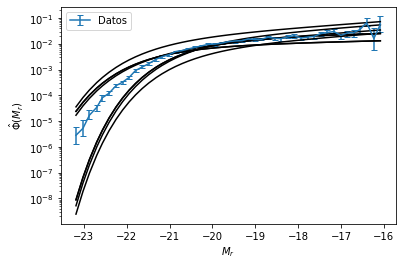

In [12]:
plt.errorbar(d['Magnitud'],d['Flujo'],yerr=[Fer_i,Fer_s], capsize=3, label='Datos')
for i in range(8):
    plt.plot(M,mod_lim[:,i],c='k')
plt.legend()
plt.xlabel('$M_r$')
plt.ylabel('$\hat{\Phi}(M_r)$')
plt.yscale('log')

In [13]:
n = 5000
step, M_chain, F_chain, a_chain = MCMC(n,M,F,Fer_i,Fer_s,Ms_i,Ms_s,fs_i,fs_s,a_i,a_s)

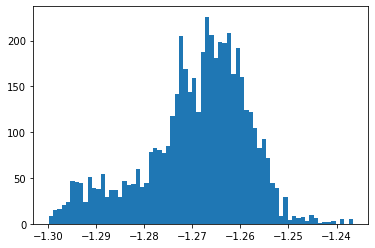

In [14]:
plt.hist(a_chain,bins=70)
plt.show()

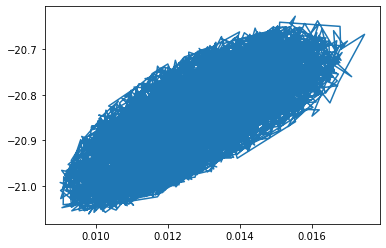

In [15]:
plt.plot(F_chain,M_chain)

## Continuará ...